<p>which python<p>
<p>source .venv/bin/activate<p>
<p>jupyter notebook --no-browser --ip=0.0.0.0<p>

In [1]:
!nvidia-smi

Wed Jul 16 15:05:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77.01              Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              9W /   95W |      14MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
print(torch.cuda.is_available())

True


# STEP 1: Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import cv2
import os
from tqdm import tqdm
import warnings
import kagglehub
warnings.filterwarnings('ignore')

In [4]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
torch.manual_seed(0)

Using device: cuda
PyTorch version: 2.7.1+cu126


# STEP 2: Load and Explore the Dataset

In [5]:
# Download and load the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
print("Path to dataset files:", path)

# Set up directory paths
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test") 
val_dir = os.path.join(path, "validation")

# Get categories from training directory
categories = os.listdir(train_dir)
print(f"There are {len(categories)} types of fruits and vegetables:\n{categories}")

def count_images_per_category(directory):
    total_images = 0
    category_counts = {}    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            image_files = [image_name for image_name in os.listdir(category_path)]
            len_category = len(image_files)
            category_counts[category] = len_category
            total_images += len_category
    return total_images, category_counts

# Get number of images found
train_total, train_cat_counts = count_images_per_category(train_dir)
val_total, val_cat_counts = count_images_per_category(val_dir)
test_total, test_cat_counts = count_images_per_category(test_dir)

print(f"\nTrain set: {train_total} images")
for cat, count in train_cat_counts.items():
    print(f" - {cat}: {count}")

print(f"\nValidation set: {val_total} images")
for cat, count in val_cat_counts.items():
    print(f" - {cat}: {count}")

print(f"\nTest set: {test_total} images")
for cat, count in test_cat_counts.items():
    print(f" - {cat}: {count}")

Path to dataset files: /home/rain/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8
There are 36 types of fruits and vegetables:
['kiwi', 'watermelon', 'paprika', 'chilli pepper', 'capsicum', 'pomegranate', 'soy beans', 'corn', 'bell pepper', 'orange', 'jalepeno', 'onion', 'grapes', 'sweetcorn', 'raddish', 'cabbage', 'turnip', 'pear', 'cauliflower', 'cucumber', 'banana', 'lettuce', 'pineapple', 'potato', 'tomato', 'mango', 'spinach', 'ginger', 'lemon', 'peas', 'garlic', 'eggplant', 'carrot', 'sweetpotato', 'beetroot', 'apple']

Train set: 3115 images
 - kiwi: 88
 - watermelon: 84
 - paprika: 83
 - chilli pepper: 87
 - capsicum: 89
 - pomegranate: 79
 - soy beans: 97
 - corn: 87
 - bell pepper: 90
 - orange: 69
 - jalepeno: 88
 - onion: 94
 - grapes: 100
 - sweetcorn: 91
 - raddish: 81
 - cabbage: 92
 - turnip: 98
 - pear: 89
 - cauliflower: 79
 - cucumber: 94
 - banana: 75
 - lettuce: 97
 - pineapple: 99
 - potato: 77
 - tomato: 92
 - mango: 86
 - sp

# STEP 3: Data Analysis and Visualization

In [6]:
# Check unique classes in training data
unique_classes = sorted(train_df['ClassId'].unique())
print(f"\nUnique classes in training: {unique_classes}")
print(f"Number of classes: {len(unique_classes)}")

# Class distribution analysis
plt.figure(figsize=(15, 5))

# Class distribution
plt.subplot(1, 3, 1)
class_counts = train_df['ClassId'].value_counts().sort_index()
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

# Image dimensions analysis
plt.subplot(1, 3, 2)
plt.scatter(train_df['Width'], train_df['Height'], alpha=0.6)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Dimensions Distribution')

# ROI (Region of Interest) analysis
plt.subplot(1, 3, 3)
roi_width = train_df['Roi.X2'] - train_df['Roi.X1']
roi_height = train_df['Roi.Y2'] - train_df['Roi.Y1']
plt.scatter(roi_width, roi_height, alpha=0.6)
plt.xlabel('ROI Width')
plt.ylabel('ROI Height')
plt.title('ROI Dimensions Distribution')

plt.tight_layout()
plt.show()

NameError: name 'train_df' is not defined

# STEP 4: Custom Dataset Class

In [7]:
class FruitVegetableDataset(Dataset):
    """
    Custom PyTorch Dataset for Fruit and Vegetable Classification
    """
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Directory containing category subdirectories
            transform: Optional transform to be applied on images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.categories = sorted(os.listdir(root_dir))
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.categories)}
        
        # Build file list
        self.samples = []
        for category in self.categories:
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                for image_name in os.listdir(category_path):
                    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((
                            os.path.join(category_path, image_name),
                            self.category_to_idx[category]
                        ))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not load image: {img_path}")
            
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Convert to PIL Image for transforms
            image = Image.fromarray(image)
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if there's an error
            if self.transform:
                image = self.transform(Image.new('RGB', (224, 224), (0, 0, 0)))
            else:
                image = torch.zeros(3, 224, 224)
            return image, label

# STEP 5: Data Transforms and Augmentation

In [8]:
# Define transforms for training (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms for validation/test (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined:")
print("- Training: Resize, Rotation, Flip, ColorJitter, Normalize")
print("- Validation: Resize, Normalize only")

Data transforms defined:
- Training: Resize, Rotation, Flip, ColorJitter, Normalize
- Validation: Resize, Normalize only


# STEP 6: Create Data Loaders

In [9]:
# Create datasets
train_dataset = FruitVegetableDataset(train_dir, transform=train_transforms)
val_dataset = FruitVegetableDataset(val_dir, transform=val_transforms)
test_dataset = FruitVegetableDataset(test_dir, transform=val_transforms)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 3115
Validation samples: 351
Test samples: 359
Batch size: 32
Training batches: 98
Validation batches: 11
Test batches: 12


# STEP 7: Visualize Sample Data

Sample training images:


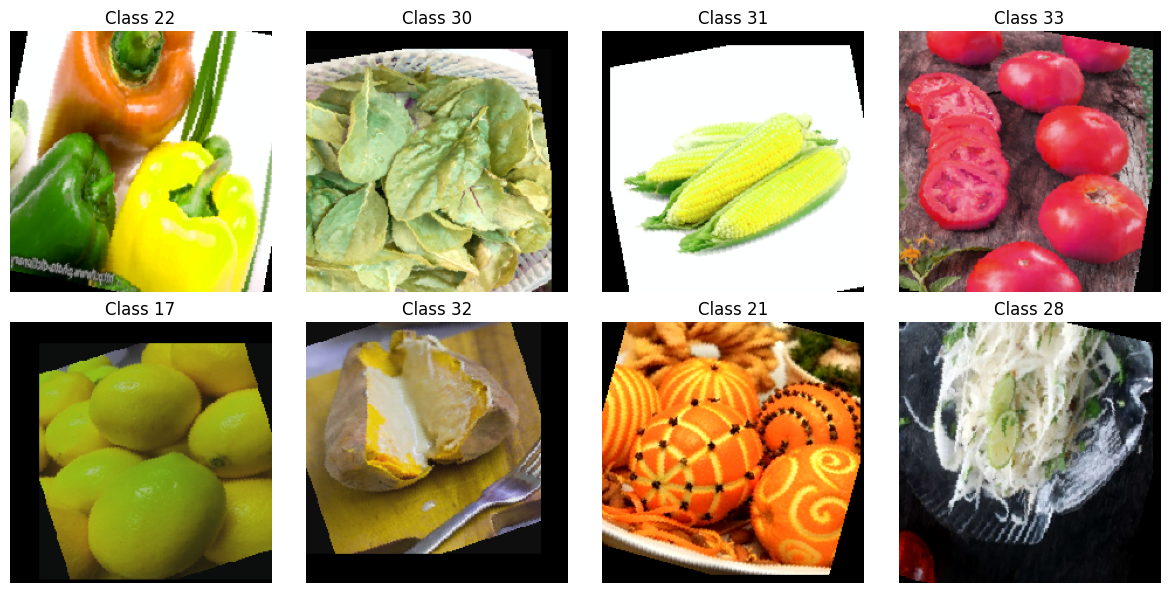

In [10]:
def imshow(tensor, title=None):
    """Display a tensor as an image"""
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = tensor.clone().detach()
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

def visualize_batch(data_loader, num_samples=8):
    """Visualize a batch of images"""
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 4, i + 1)
        imshow(images[i], title=f'Class {labels[i].item()}')
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Sample training images:")
visualize_batch(train_loader)

# STEP 8: Model Architecture

In [11]:
class ArtStyleClassifier(nn.Module):
    """
    CNN model for art style classification using transfer learning
    
    Architecture:
    - Pre-trained ResNet50 as backbone
    - Custom classifier head
    - Dropout for regularization
    """
    
    def __init__(self, num_classes, pretrained=True):
        super(ArtStyleClassifier, self).__init__()
        
        # Load pre-trained ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Get the number of features from the last layer
        num_features = self.backbone.fc.in_features
        
        # Replace the final layer with custom classifier
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Alternative: EfficientNet model
class EfficientNetClassifier(nn.Module):
    """
    Alternative model using EfficientNet
    """
    
    def __init__(self, num_classes, pretrained=True):
        super(EfficientNetClassifier, self).__init__()
        
        # Load pre-trained EfficientNet
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        
        # Get the number of features
        num_features = self.backbone.classifier[1].in_features
        
        # Replace classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Update number of classes based on the dataset
num_classes = len(categories)
print(f"Number of classes: {num_classes}")

# Create model
model = ArtStyleClassifier(num_classes, pretrained=True)
# model = EfficientNetClassifier(num_classes, pretrained=True)

# Move model to device
model = model.to(device)

# Display model info
print(f"Model created with {num_classes} classes")
print(f"Model moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Number of classes: 36
Model created with 36 classes
Model moved to cuda
Total parameters: 24,697,700
Trainable parameters: 24,697,700


# STEP 9: Loss Function and Optimizer

In [12]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("Training setup:")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"Scheduler: StepLR (step_size=10, gamma=0.1)")

Training setup:
Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001, weight_decay=1e-4)
Scheduler: StepLR (step_size=10, gamma=0.1)


# STEP 10: Training Functions

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    
    Returns:
        Average loss and accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    
    Returns:
        Average loss, accuracy, and F1 score for the epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions for F1 score calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    # Calculate F1 score
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    
    return epoch_loss, epoch_acc, f1_macro, f1_weighted

# STEP 11: Training Loop

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    """
    Complete training loop with validation
    
    Returns:
        Training history dictionary
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1_macro': [],
        'val_f1_weighted': []
    }
    
    best_f1 = 0.0
    best_model_state = None
    
    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, val_f1_macro, val_f1_weighted = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Save best model
        if val_f1_macro > best_f1:
            best_f1 = val_f1_macro
            best_model_state = model.state_dict().copy()
            print(f"New best F1 score: {best_f1:.4f}")
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(val_f1_macro)
        history['val_f1_weighted'].append(val_f1_weighted)
        
        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Val F1 (Macro): {val_f1_macro:.4f}, Val F1 (Weighted): {val_f1_weighted:.4f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print("-" * 50)
        
        # Early stopping check
        if epoch > 10 and val_f1_macro < max(history['val_f1_macro'][-10:]) - 0.01:
            print("Early stopping triggered!")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best model loaded with F1 score: {best_f1:.4f}")
    
    return history

In [15]:
# Start training
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5)

Starting training for 5 epochs...
--------------------------------------------------
Epoch 1/5


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.64it/s, Loss=2.7454, Acc=11.40%]


New best F1 score: 0.0540
Train Loss: 3.4518, Train Acc: 7.45%
Val Loss: 3.6175, Val Acc: 11.40%
Val F1 (Macro): 0.0540, Val F1 (Weighted): 0.0553
Current LR: 0.001000
--------------------------------------------------
Epoch 2/5


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.65it/s, Loss=3.1526, Acc=13.39%]


New best F1 score: 0.0690
Train Loss: 3.2346, Train Acc: 9.95%
Val Loss: 2.9390, Val Acc: 13.39%
Val F1 (Macro): 0.0690, Val F1 (Weighted): 0.0697
Current LR: 0.001000
--------------------------------------------------
Epoch 3/5


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.67it/s, Loss=2.6204, Acc=14.53%]


New best F1 score: 0.0812
Train Loss: 3.0956, Train Acc: 12.17%
Val Loss: 2.6832, Val Acc: 14.53%
Val F1 (Macro): 0.0812, Val F1 (Weighted): 0.0827
Current LR: 0.001000
--------------------------------------------------
Epoch 4/5


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.69it/s, Loss=2.8400, Acc=16.81%]


New best F1 score: 0.1252
Train Loss: 2.9853, Train Acc: 14.00%
Val Loss: 2.7600, Val Acc: 16.81%
Val F1 (Macro): 0.1252, Val F1 (Weighted): 0.1258
Current LR: 0.001000
--------------------------------------------------
Epoch 5/5


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.71it/s, Loss=2.7477, Acc=24.22%]

New best F1 score: 0.1627
Train Loss: 2.9410, Train Acc: 15.06%
Val Loss: 2.4443, Val Acc: 24.22%
Val F1 (Macro): 0.1627, Val F1 (Weighted): 0.1639
Current LR: 0.001000
--------------------------------------------------
Best model loaded with F1 score: 0.1627


# STEP 12: Training Visualization

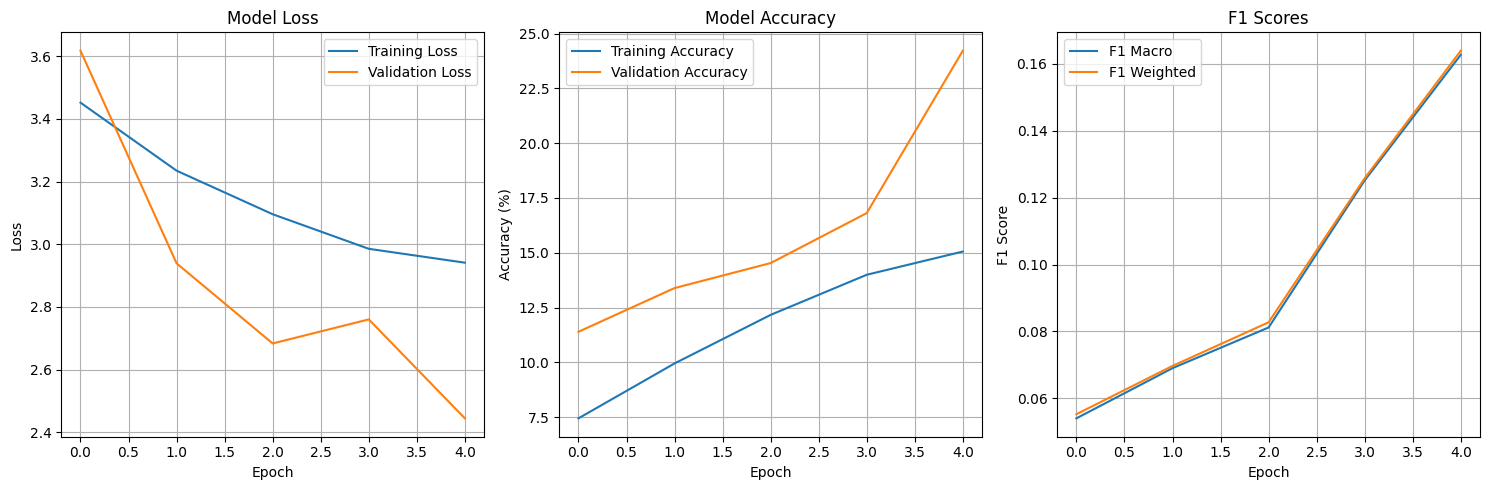

In [16]:
def plot_training_history(history):
    """
    Plot training history
    """
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(history['val_f1_macro'], label='F1 Macro')
    plt.plot(history['val_f1_weighted'], label='F1 Weighted')
    plt.title('F1 Scores')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# STEP 13: Model Evaluation

In [17]:
def evaluate_model(model, val_loader, device):
    """
    Comprehensive model evaluation
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Final F1 Score (Macro): {f1_macro:.4f}")
    print(f"Final F1 Score (Weighted): {f1_weighted:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return f1_macro, f1_weighted, all_probabilities

Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.75it/s]


Final F1 Score (Macro): 0.1627
Final F1 Score (Weighted): 0.1639

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.21      0.56      0.30         9
           2       0.40      0.40      0.40        10
           3       0.00      0.00      0.00         9
           4       0.15      0.80      0.25        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         9
           7       1.00      0.10      0.18        10
           8       0.11      0.11      0.11         9
           9       0.29      1.00      0.45        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.25      0.80      0.38        10
          13       0.00      0.00      0.00        10
          14       0.31      0.89      0.46         9
          15       0.33      0.11      0.17   

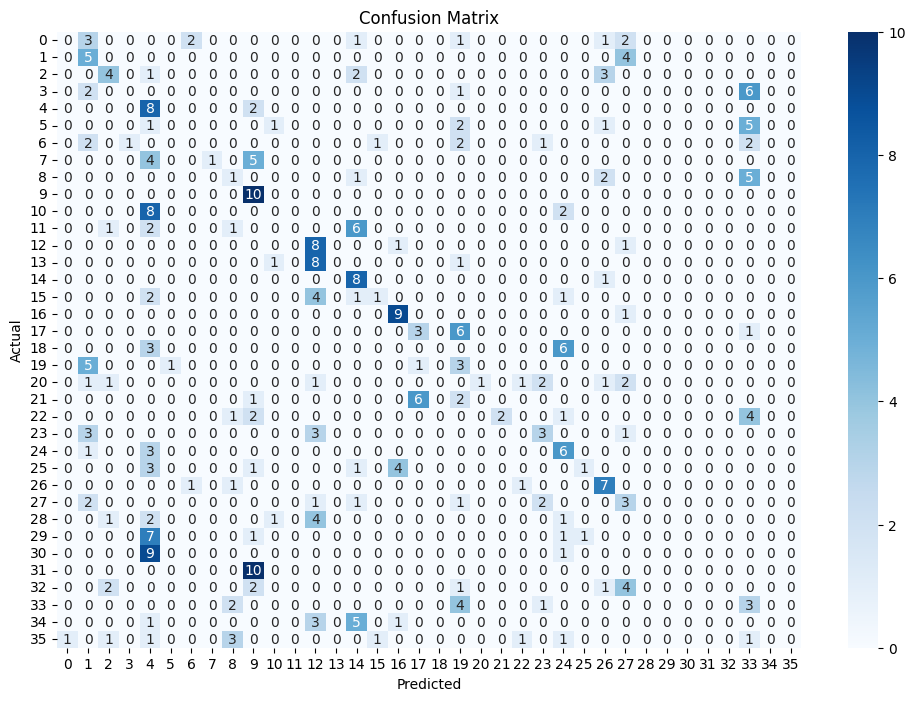

In [18]:
# Evaluate the model
f1_macro, f1_weighted, val_probabilities = evaluate_model(model, val_loader, device)

# STEP 14: Test Data Prediction

In [19]:
def predict_test_data(model, test_loader, device):
    """
    Make predictions on test data
    """
    model.eval()
    all_predictions = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc='Predicting'):
            images = images.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_probabilities)

In [20]:
# Make predictions on test data
print("Making predictions on test data...")
test_predictions, test_probabilities = predict_test_data(model, test_loader, device)

Making predictions on test data...


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.74it/s]


# STEP 15: Handle Unknown Class (11th Class)

In [21]:
def detect_unknown_class(predictions, probabilities, threshold=0.7):
    """
    Detect potential unknown class based on prediction confidence
    
    Args:
        predictions: Predicted class labels
        probabilities: Prediction probabilities for each class
        threshold: Confidence threshold below which we classify as unknown
    
    Returns:
        Modified predictions with unknown class
    """
    # Get maximum probability for each prediction
    max_probabilities = np.max(probabilities, axis=1)
    
    # Create a copy of predictions
    modified_predictions = predictions.copy()
    
    # Mark low-confidence predictions as unknown class (assuming class 10 is unknown)
    unknown_mask = max_probabilities < threshold
    modified_predictions[unknown_mask] = 10  # Unknown class
    
    print(f"Detected {np.sum(unknown_mask)} potential unknown class samples")
    print(f"Percentage of unknown samples: {np.sum(unknown_mask)/len(predictions)*100:.2f}%")
    
    return modified_predictions

In [22]:
# Detect unknown class samples
final_predictions = detect_unknown_class(test_predictions, test_probabilities, threshold=0.6)

Detected 336 potential unknown class samples
Percentage of unknown samples: 93.59%


# STEP 16: Create Submission File

In [23]:
def create_submission(test_dataset, predictions, output_file='submission.csv'):
    """
    Create submission file in required format
    """
    # Create submission dataframe
    submission_data = []
    for i, (img_path, true_label) in enumerate(test_dataset.samples):
        submission_data.append({
            'Path': img_path,
            'TrueLabel': test_dataset.categories[true_label],
            'PredictedLabel': test_dataset.categories[predictions[i]],
            'PredictedClassId': predictions[i]
        })
    
    submission_df = pd.DataFrame(submission_data)
    
    # Save submission file
    submission_df[['Path', 'PredictedLabel', 'PredictedClassId']].to_csv(output_file, index=False)
    
    print(f"Submission file saved as {output_file}")
    
    # Display prediction distribution
    pred_counts = pd.Series(predictions).value_counts().sort_index()
    print("\nPrediction distribution:")
    for class_id, count in pred_counts.items():
        print(f"Class {class_id} ({test_dataset.categories[class_id]}): {count}")
    
    return submission_df

In [24]:
# Create submission file
submission = create_submission(test_dataset, final_predictions, output_file="submissionOOD.csv")

Submission file saved as submissionOOD.csv

Prediction distribution:
Class 9 (corn): 13
Class 10 (cucumber): 336
Class 16 (kiwi): 10


# STEP 17: Model Saving and Loading

In [25]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': num_classes,
    'f1_score': f1_macro,
    'history': history
}, 'art_style_classifierOOD.pth')

print("Model saved as 'art_style_classifierOOD.pth'")

Model saved as 'art_style_classifierOOD.pth'


In [26]:
# Function to load the model
def load_model(model_path, num_classes):
    """
    Load a saved model
    """
    model = ArtStyleClassifier(num_classes)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    print(f"Model loaded from {model_path}")
    print(f"Best F1 score: {checkpoint['f1_score']:.4f}")
    
    return model

# Example of loading the model
# loaded_model = load_model('art_style_classifier.pth', num_classes)

# STEP 18: Advanced Features (Optional)

In [27]:
# Model ensemble example
def create_ensemble_predictions(models, test_loader, device):
    """
    Create ensemble predictions from multiple models
    """
    all_predictions = []
    
    for model in models:
        model.eval()
        model_predictions = []
        
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = model(images)
                probabilities = F.softmax(outputs, dim=1)
                model_predictions.append(probabilities.cpu().numpy())
        
        all_predictions.append(np.concatenate(model_predictions))
    
    # Average predictions
    ensemble_predictions = np.mean(all_predictions, axis=0)
    final_predictions = np.argmax(ensemble_predictions, axis=1)
    
    return final_predictions, ensemble_predictions

# Gradient-weighted Class Activation Mapping (Grad-CAM)
def generate_gradcam(model, image, class_idx, target_layer):
    """
    Generate Grad-CAM heatmap for model interpretability
    """
    model.eval()
    
    # Forward pass
    features = []
    def hook_fn(module, input, output):
        features.append(output)
    
    handle = target_layer.register_forward_hook(hook_fn)
    
    image = image.unsqueeze(0).to(device)
    output = model(image)
    
    # Backward pass
    model.zero_grad()
    output[0, class_idx].backward()
    
    # Get gradients and features
    gradients = target_layer.weight.grad
    activations = features[0]
    
    # Generate heatmap
    weights = torch.mean(gradients, dim=(2, 3))
    heatmap = torch.zeros(activations.shape[2:]).to(device)
    
    for i in range(weights.shape[1]):
        heatmap += weights[0, i] * activations[0, i]
    
    heatmap = F.relu(heatmap)
    heatmap = heatmap / torch.max(heatmap)
    
    handle.remove()
    
    return heatmap.cpu().numpy()

# STEP 19: Summary and Results

Model loaded from art_style_classifierOOD.pth
Best F1 score: 0.1627
Making predictions on test data...


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.18it/s]


Final F1 Score (Macro): 0.1627
Final F1 Score (Weighted): 0.1639

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.21      0.56      0.30         9
           2       0.40      0.40      0.40        10
           3       0.00      0.00      0.00         9
           4       0.15      0.80      0.25        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         9
           7       1.00      0.10      0.18        10
           8       0.11      0.11      0.11         9
           9       0.29      1.00      0.45        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.25      0.80      0.38        10
          13       0.00      0.00      0.00        10
          14       0.31      0.89      0.46         9
          15       0.33      0.11      0.17   

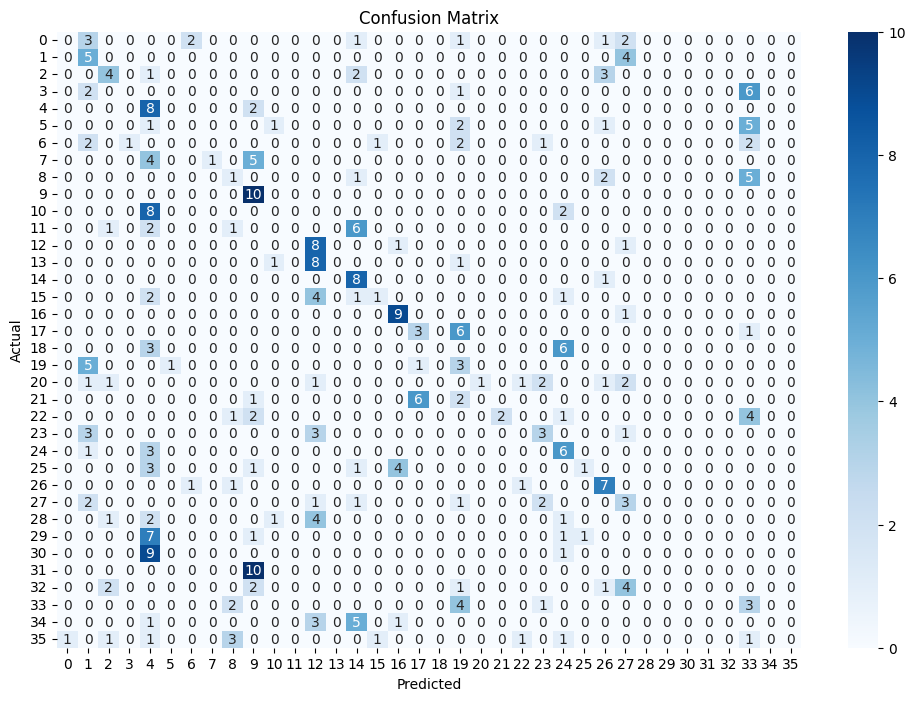

Detected 336 potential unknown class samples
Percentage of unknown samples: 93.59%


In [33]:
# Option to load model instead of training
USE_SAVED_MODEL = True  # Set to True if you want to load a saved model

# Updated load_model function to return history
def load_model_with_history(model_path, num_classes):
    """
    Load a saved model along with its training history
    """
    model = ArtStyleClassifier(num_classes)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    # Extract history if available
    history = checkpoint.get('history', None)
    f1_score = checkpoint.get('f1_score', 0.0)
    
    print(f"Model loaded from {model_path}")
    print(f"Best F1 score: {f1_score:.4f}")
    
    return model, history

if USE_SAVED_MODEL:
    # Load the saved model
    loaded_model, history = load_model_with_history('art_style_classifierOOD.pth', num_classes)
    model = loaded_model
    
    # If no history available, skip visualization or create dummy
    if history is None:
        print("No training history available - skipping training plots")
        # You can either skip plot_training_history() or create dummy data
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'val_f1_macro': [],
            'val_f1_weighted': []
        }
else:
    # Use the freshly trained model (existing code continues)
    history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)
    
# Make predictions on test data
print("Making predictions on test data...")
test_predictions, test_probabilities = predict_test_data(model, test_loader, device)
# Continue with evaluation
f1_macro, f1_weighted, val_probabilities = evaluate_model(model, val_loader, device)
# Detect unknown class samples
final_predictions = detect_unknown_class(test_predictions, test_probabilities, threshold=0.6)

In [34]:
print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"Final F1 Score (Macro): {f1_macro:.4f}")
print(f"Final F1 Score (Weighted): {f1_weighted:.4f}")
print(f"Number of test predictions: {len(final_predictions)}")
print(f"Model saved: art_style_classifier.pth")
print(f"Submission file: submission.csv")
print(f"Device used: {device}")
print(f"Total training time: {len(history['train_loss'])} epochs")

print("\nModel Architecture:")
print(f"- Base model: ResNet50 (pre-trained)")
print(f"- Number of classes: {num_classes}")
print(f"- Total parameters: {total_params:,}")

print("\nNext steps to improve performance:")
print("1. Try different architectures (EfficientNet, Vision Transformer)")
print("2. Experiment with different data augmentation techniques")
print("3. Implement test-time augmentation (TTA)")
print("4. Use model ensembling")
print("5. Fine-tune hyperparameters")
print("6. Implement advanced loss functions (Focal Loss, Label Smoothing)")
print("7. Use cross-validation for more robust evaluation")
print("8. Analyze model predictions with Grad-CAM")


TRAINING COMPLETE - SUMMARY
Final F1 Score (Macro): 0.1627
Final F1 Score (Weighted): 0.1639
Number of test predictions: 359
Model saved: art_style_classifier.pth
Submission file: submission.csv
Device used: cuda
Total training time: 5 epochs

Model Architecture:
- Base model: ResNet50 (pre-trained)
- Number of classes: 36
- Total parameters: 24,697,700

Next steps to improve performance:
1. Try different architectures (EfficientNet, Vision Transformer)
2. Experiment with different data augmentation techniques
3. Implement test-time augmentation (TTA)
4. Use model ensembling
5. Fine-tune hyperparameters
6. Implement advanced loss functions (Focal Loss, Label Smoothing)
7. Use cross-validation for more robust evaluation
8. Analyze model predictions with Grad-CAM
